In [1]:
import os
import sys
import glob
import scipy
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path.append('/home/alexcc/strains_analysis/')
import strainRepOneSample

In [3]:
s = strainRepOneSample.SNVdata()
s.load('/data5/eelriver/CYA2/strainRep/output/PH2015_06_Oscillatoriales2_46_199')

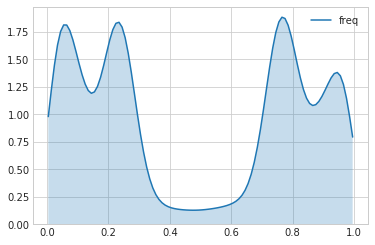

In [4]:
sns.kdeplot(s.snv_table['freq'], shade=True, cut=0);
# sns.rugplot(s.snv_table['freq']);

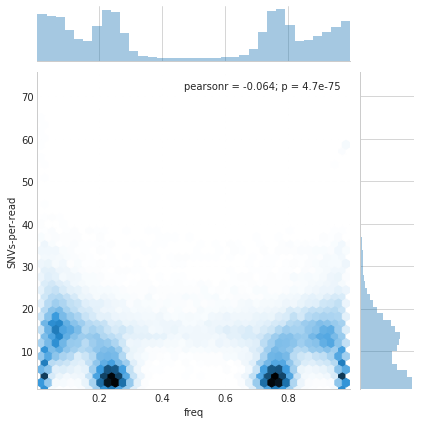

In [44]:
sns.jointplot(x="freq", y="SNVs-per-read", data=s.snv_table, kind="hex");

In [5]:
import networkx as nx
def calc_graph(self):
    ''' Takes the snv_net object and creates a networkx network object from it.
    Not called automatically, for use in jupyter notebooks to play around with net.
    '''
    if self.snv_net:
        #create networkx graph
        G=nx.Graph()
        #add nodes
        nodes = set()
        for edge in self.snv_net:
            nodes_set = list(edge)
            node1 = nodes_set[0]
            node2 = nodes_set[1]
            if node1 not in nodes:
                G.add_node(node1)
                nodes.add(node1)
            if node2 not in nodes:
                G.add_node(node2) 
                nodes.add(node2)
            G.add_edge(node1,node2, weight=self.snv_net[edge])
        self.graph = G
    else:
        print("ERROR: NO LINKAGE NET GENERATED")
        return False


In [7]:
nx.algorithms.number_connected_components(s.graph)

3014

In [17]:
print(len(s.graph))
print(s.graph.number_of_edges())
G = calc_graph(s)
G = s.graph

80694
1268066


In [18]:
components = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)

In [254]:
## node2vec

G_save = nx.convert_node_labels_to_integers(components[7], label_attribute="old_name")
graph_file = '/home/alexcc/strains_analysis/test8.net'
nx.write_weighted_edgelist(G_save, graph_file)

In [255]:
from gensim.models import Word2Vec
from deepwalk import graph
import random
from sklearn.decomposition import PCA
from matplotlib import pyplot
import node2vec


In [381]:

nx_G = components[2]

G = node2vec.Graph(nx_G, False, 0.1, 1)
print("preprocessing...")
G.preprocess_transition_probs()
print("wals...")
walks = G.simulate_walks(10, 10)
print("learning...")

# walks = [map(str, walk) for walk in walks]
model = Word2Vec(walks, size=128, window=10, min_count=0, sg=1, workers=6, iter=1)
# model.save_word2vec_format(args.output)


preprocessing...
wals...
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
learning...


In [382]:
model
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [383]:
node_freqs = {}
for node in nx_G.nodes(data=True):
        node_freqs[node[0]] = float(s.snv_table.loc[s.snv_table['SNV'] == node[0]]['freq'])
        
result_df = pd.DataFrame(data=result)
nodes_list = list(model.wv.vocab)

for i, row in result_df.iterrows():
  result_df.at[i,'freq'] = node_freqs[nodes_list[int(i)]]

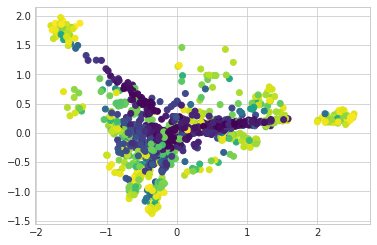

In [384]:
plt.scatter(x=result_df[0], y=result_df[1], c=result_df['freq'], cmap=plt.cm.viridis)
plt.show()

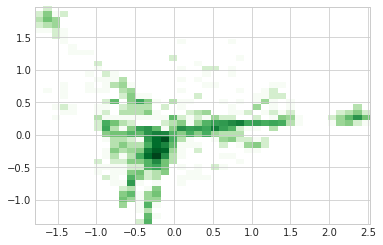

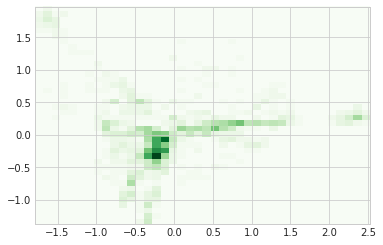

In [385]:
import matplotlib.colors as colors

matplotlib.pyplot.hist2d(result[:, 0], result[:, 1], bins=40, norm=colors.LogNorm(), cmap='Greens')
plt.show()

matplotlib.pyplot.hist2d(result[:, 0], result[:, 1], bins=40, cmap='Greens')
plt.show()

In [ ]:
### Deepwalk - NOT weighted??

In [238]:
## Deep walk instead of node2vec
print("loading")
G = graph.load_edgelist(graph_file, undirected=True)
print("building walks")
walks = graph.build_deepwalk_corpus(G, num_paths=80, path_length=3, alpha=0, rand=random.Random(999))
print("building model")
model = Word2Vec(walks, size=128, window=10, min_count=0, sg=1, hs=1, workers=10)

loading
building walks
building model


In [244]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
model
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [245]:
node_freqs = {}
for node in G_save.nodes(data=True):
        node_name = node[1]['old_name']
        node_freqs[node[0]] = float(s.snv_table.loc[s.snv_table['SNV'] == node_name]['freq'])

In [247]:
result_df = pd.DataFrame(data=result)
nodes_list = list(model.wv.vocab)

for i, row in result_df.iterrows():
  result_df.at[i,'freq'] = node_freqs[int(nodes_list[int(i)])]

KeyError: 'PH2015_06_scaffold_837_6306:G'

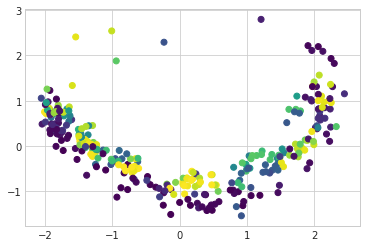

In [217]:
plt.scatter(x=result_df[0], y=result_df[1], c=result_df['freq'], cmap=plt.cm.viridis)
plt.show()

In [185]:
np.histogram2d(result, bins=100)

TypeError: histogram2d() missing 1 required positional argument: 'y'

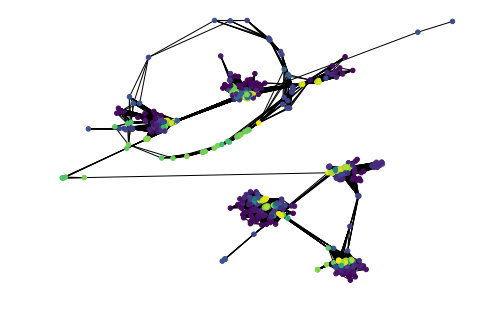

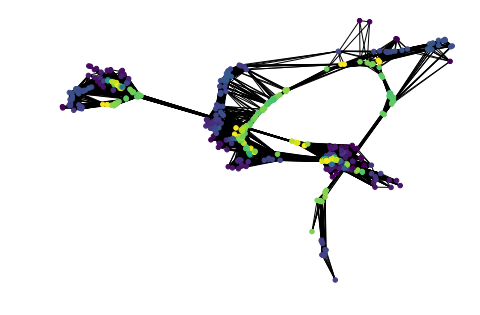

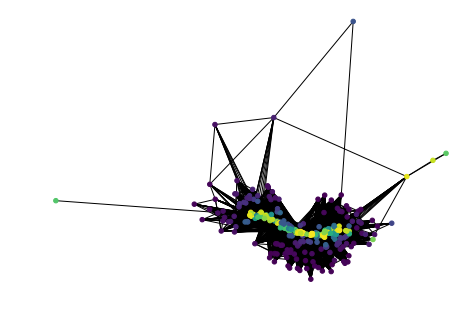

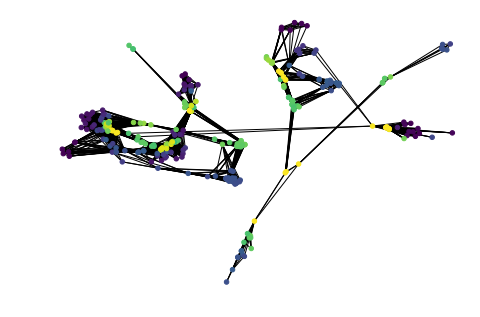

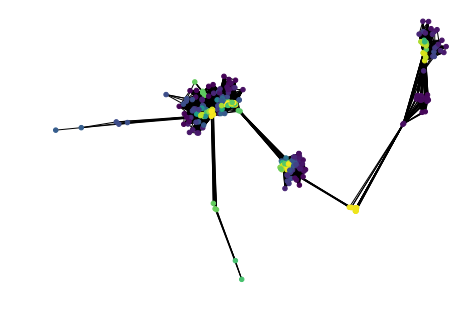

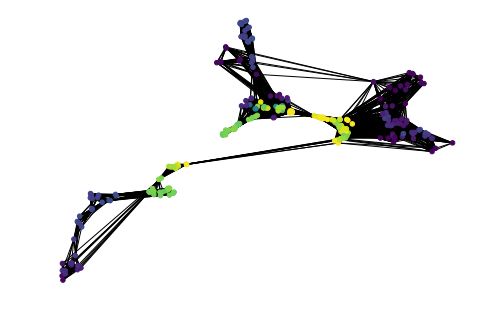

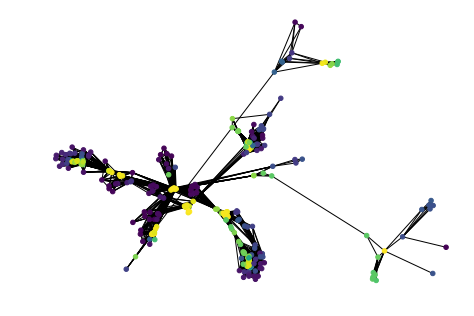

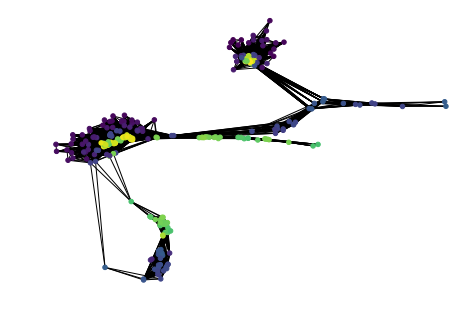

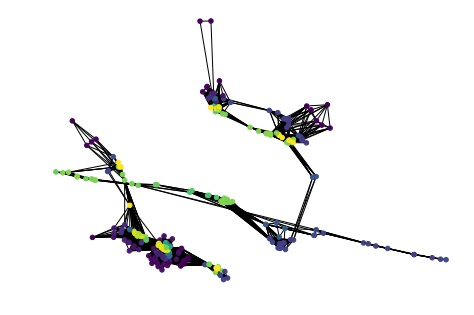

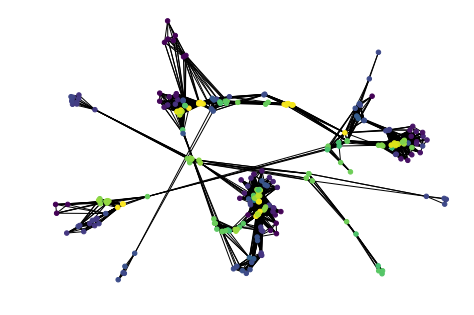

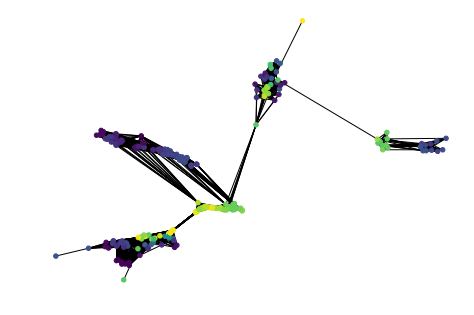

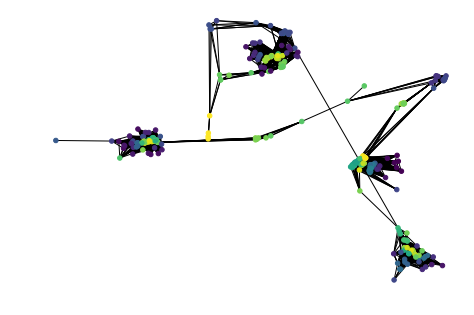

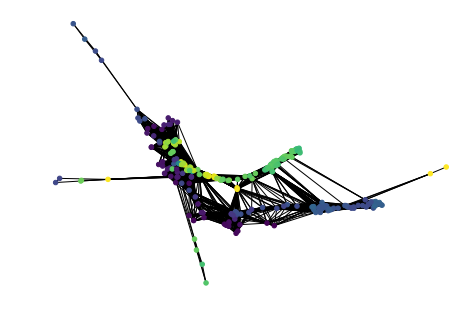

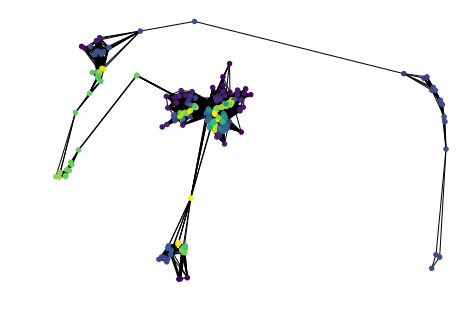

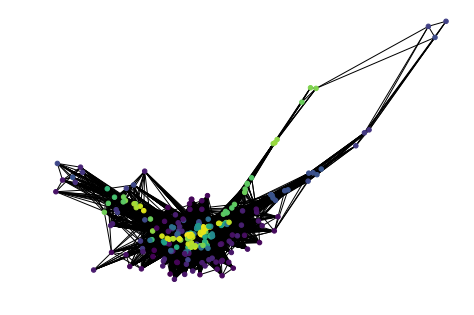

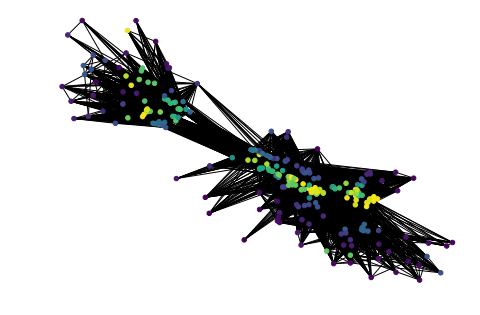

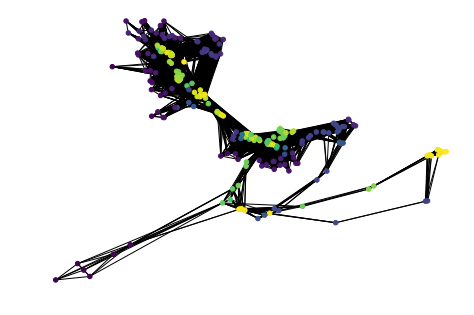

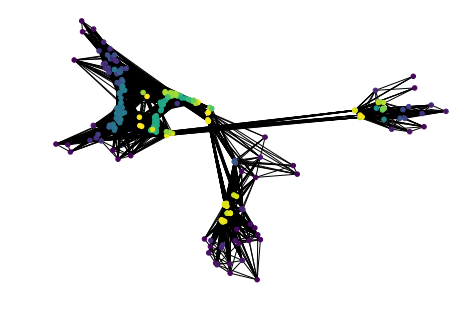

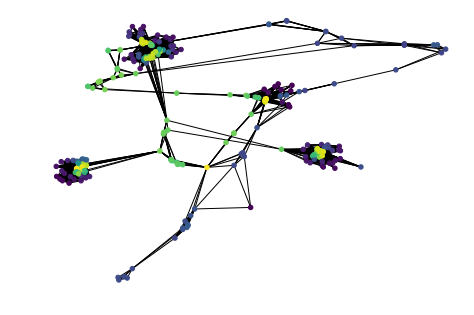

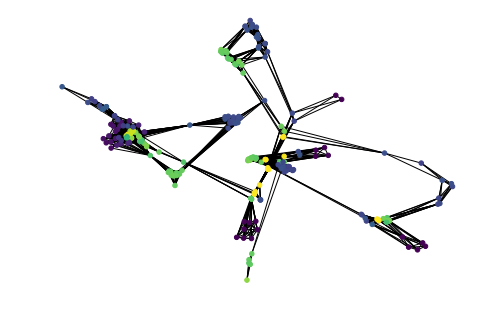

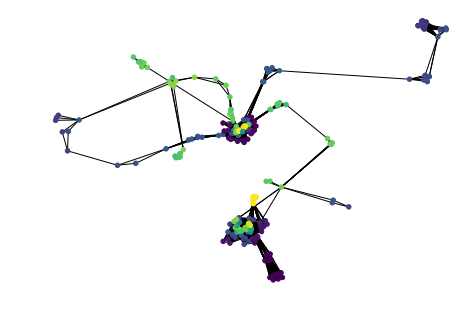

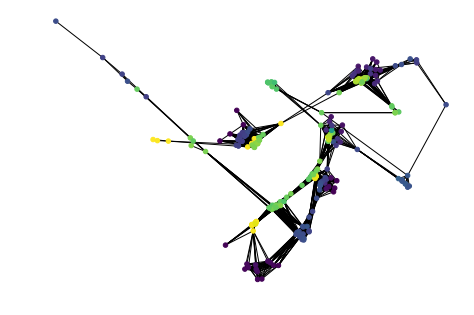

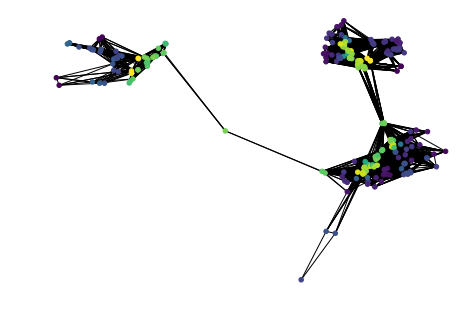

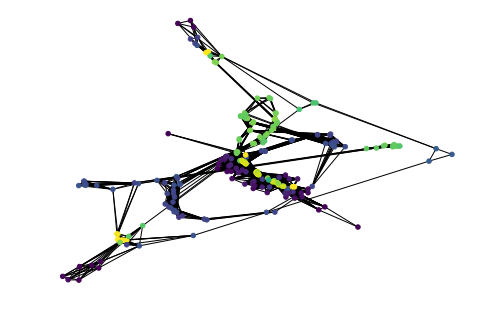

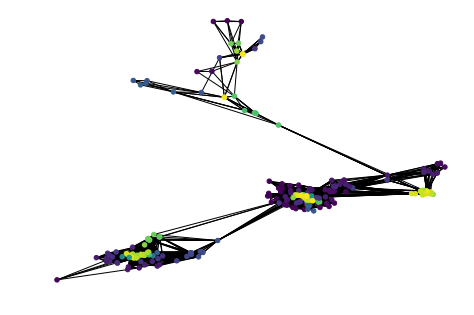

In [193]:
for component in components[5:30]:
    
    for node in component.nodes(data=True):
        component.node[node[0]]['freq'] = float(s.snv_table.loc[s.snv_table['SNV'] == node[0]]['freq'])
    
    node_color = [component.node[node]['freq'] for node in component]

    
    nx.draw_spring(component, node_color = node_color, node_size=20, cmap = plt.cm.viridis)

    plt.show()

## More plots





In [36]:
s2 = strainRepOneSample.SNVdata()
s2.load('/data5/eelriver/CYA2/strainRep/output/PH2015_02_Oscillatoriales_45_235')

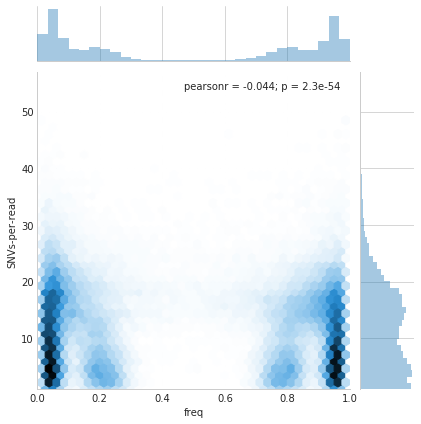

In [37]:
sns.jointplot(x="freq", y="SNVs-per-read", data=s2.snv_table, kind="hex");

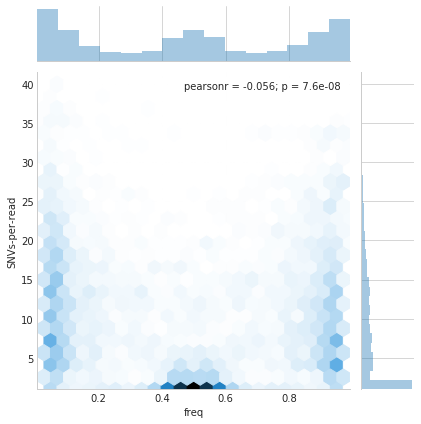

In [38]:
s3 = strainRepOneSample.SNVdata()
s3.load('/data5/eelriver/CYA2/strainRep/output/PH2015_09_Oscillatoriales_56_116')
sns.jointplot(x="freq", y="SNVs-per-read", data=s3.snv_table, kind="hex");

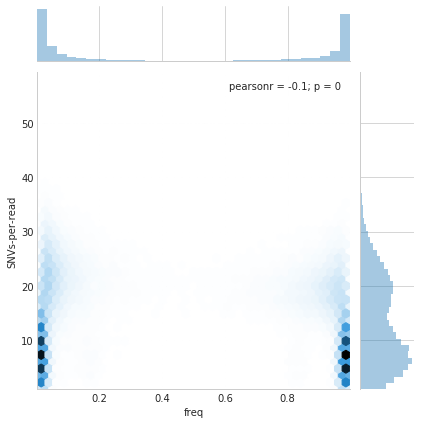

In [40]:
s4 = strainRepOneSample.SNVdata()
s4.load('/data5/eelriver/CYA2/strainRep/output/PH2015_01_Oscillatoria_nigro-viridiss_45_393')
sns.jointplot(x="freq", y="SNVs-per-read", data=s4.snv_table, kind="hex");

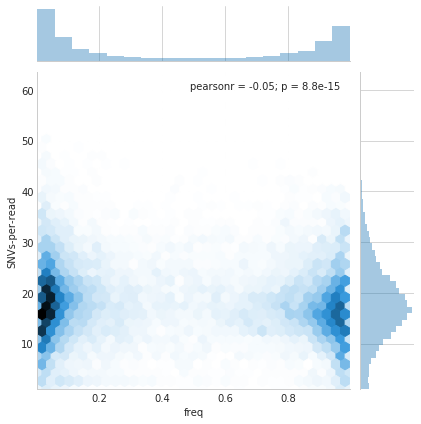

In [41]:
s5 = strainRepOneSample.SNVdata()
s5.load('/data5/eelriver/CYA2/strainRep/output/PH2015_03_Oscillatoriales_45_315')
sns.jointplot(x="freq", y="SNVs-per-read", data=s5.snv_table, kind="hex");


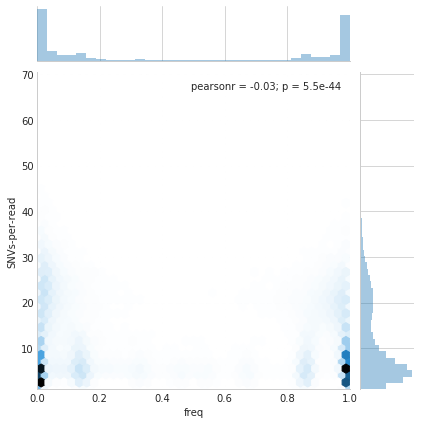

In [70]:
s6 = strainRepOneSample.SNVdata()
s6.load('/data5/eelriver/CYA2/strainRep/output/PH2015_14_Oscillatoriales_45_708')
sns.jointplot(x="freq", y="SNVs-per-read", data=s6.snv_table, kind="hex");